# Extract MTA Data from archives

This notebook helps automate extracting data from the protobufs manually downloaded from [Historical GTFS data](http://web.mta.info/developers/data/archives.html)the latest source suggested at:
https://groups.google.com/d/msg/mtadeveloperresources/Whm5XTVINcE/z-LO12ANAAAJ

Note that another S3 hosted [historical datasource](http://web.mta.info/developers/MTA-Subway-Time-historical-data.html) referenced on the MTA website, but this is outdated, and the above MTA Alert Archive is correct.

NOTE: This notebook assumes that the protobufs have already been downloaded to <code>data/raw/status</code> e.g. <code>data/raw/status/201901.zip</code> from http://web.mta.info/developers/data/archives.html

In [1]:
import os
import pandas as pd
import sys
data_dir = '/data/raw/status'

In [2]:
import glob
protobuf_paths = glob.glob('{}/[0-9]*.zip'.format(data_dir))

if len(protobuf_paths) == 0:
    raise ValueError('No matching protbufs found in {}, please download from https://m.mymtaalerts.com/archive')
    
print(protobuf_paths)

ValueError: No matching protbufs found in {}, please download from https://m.mymtaalerts.com/archive

### Helper cell for recursively unzipping monthly rollups
This is a bit finnicky, as the layout and zip format vary from month-to month, but this is a helpful tool for unzipping some of the.  This will fail for a handful of the monthly archives, and you will either need to modify it, or manually handle those cases.  Especially watch out for <code>201812.zip</code>, as that contains <code>201812.7z</code>

Additionally, there are a small number of corrupted daily zips, so this absorbs and logs those errors.

In [3]:
import zipfile
import shutil
import progressbar
import io

In [4]:


# Keep a list of files with failed extractions
failed_files = os.path.join(data_dir, 'failures.txt')

force = False

# unzip monthly rollups, then unzip the daily files inside
# This code is largely copied from: https://stackoverflow.com/questions/36285502/how-to-extract-zip-file-recursively-in-python
# The daily zipfiles are ~1GB, so there are big speed gains from unzipping in memory
#for monthly_file in protobuf_paths[-1:]:
for monthly_file in ['../data/raw/status/201906.zip',]:
    widgets = [progressbar.Percentage(), progressbar.Bar(), progressbar.Variable('failures')]    

    
    print("Extracting: " + monthly_file)
    z = zipfile.ZipFile(monthly_file)
    for i,f in enumerate(z.namelist()):
        print("{}/{}".format(i+1, len(z.namelist())))
        # get directory name from file
        dirname = os.path.join(data_dir, os.path.splitext(f)[0])
        # create new directory
        os.makedirs(dirname, exist_ok=True)
        # read inner zip file into bytes buffer 
        content = io.BytesIO(z.read(f))
        zip_file = zipfile.ZipFile(content)
        
        # Skip if already unzipped
        if not force:
            if len(glob.glob(dirname+'/*')) == len(zip_file.namelist()):
                print("Skipping " + os.path.basename(dirname))
                continue
         
        # Iterate through in-memory zipfile, dumping sub-minutely protobufs into daily directories
        bar = progressbar.ProgressBar(widgets=widgets, max_value=len(zip_file.namelist()), min_poll_interval=.5).start()
        failures = 0
        for j,f2 in enumerate(zip_file.namelist()):
            try:
                zip_file.extract(f2, dirname)
            except Exception as e:
                # At the moment, some messages a sporadically unable to parse
                with io.open(failed_files, 'a') as fh:
                    fh.write(f2+'\n')
                failures += 1
                
            sys.stdout.flush()
            bar.update(j+1, failures=failures)
        zip_file.close()
        
        bar.finish()
    
    

Extracting: ../data/raw/status/201906.zip
1/30
Skipping 20190601
2/30


KeyboardInterrupt: 

# Extract GTFS into H5
Extract relevant info from GTFS files to H5.  Right now this is just extracting the current train in a station at a given time, and information about which train is expected to arrive next, and when.  It is possible that more information will be added, but this is too heavy-weight to include in [DatExploration.ipynb](DataExploration.ipyny), and should only be run as part of data processing

In [15]:
from functools import lru_cache

In [16]:
# relative MTADelayPredict Project
import sys
import os
import pandas as pd

sys.path.append(os.path.dirname(os.path.dirname(os.path.realpath(os.path.join('DataExploration.ipynb')))))
from MTADelayPredict.data_processing import train_data, gtfs_loader

from importlib import reload
reload(gtfs_loader)

<module 'MTADelayPredict.data_processing.gtfs_loader' from '/opt/project/MTADelayPredict/data_processing/gtfs_loader.py'>

In [17]:
STOP_FILTER = '^.*N$'
ROUTE_FILTER = 'N'
data_dir = '/data/raw/status'

start_date = pd.Timestamp('2018-08-01 11:26:00-04:00', tz='US/Eastern')
end_date = pd.Timestamp('2018-08-01 15:26:00-04:00', tz='US/Eastern')
train_line = 'nqrw'
loader = gtfs_loader.GTFSLoader(data_dir=data_dir,
                                train_line=train_line)
data = loader.load_range(start_date, end_date, stop_filter=STOP_FILTER, route_filter=ROUTE_FILTER, verbose=True,
                  schedule=True)

25552526
25552646


100%|#####################################|entries: ------decode_errors:      5


New stops:
{'R32S', 'N02S', 'N05S', 'R06S', 'R39S', 'Q01S', 'R16S', 'R04S', 'R34S', 'R30S', 'R15S', 'R03S', 'R17S', 'R31S', 'R01S', 'R35S', 'R11S', 'N09S', 'N07S', 'D43S', 'R41S', 'Q01N', 'R60S', 'N10S', 'N06S', 'N03S', 'R33S', 'R40S', 'R36S', 'N08S', 'R13S', 'R60N', 'R14S', 'R09S', 'R20S', 'N04S'}


In [34]:
# Create loaders for loading data in monthly chunks
loader_start = pd.Timestamp('2019-02-28 00:00:00', tz='US/Eastern')
loader_end =  pd.Timestamp('2019-04-30 23:59:59', tz='US/Eastern')
drange = pd.date_range(start=loader_start, end=loader_end, freq='D')
loaders = []

# Build separate loaders per month
for i,d in enumerate(drange):
    start_date = d.replace(hour=0, minute=0, second=0)
    end_date = d.replace(hour=23,minute=59,second=59)
    loader = gtfs_loader.GTFSLoader(data_dir=data_dir,
                                    train_line=train_line)
    loaders.append((loader, start_date, end_date))
    

In [35]:
# Load months in a pool and cache to h5
from multiprocessing import Pool
import os
#STOP_FILTER = '^R1[6-9]N$'
#STOP_FILTER = '^R1[6-7]N$'
STOP_FILTER = '^.*N$'
#ROUTE_FILTER = '[N|Q|R|W]'
ROUTE_FILTER = 'N'

status_dir = os.path.join(data_dir, 'status_northbound_n_schedule')

failed_dates = []

def f(args):
    loader, start_date, end_date = args
    try:
        file_dir = os.path.join(status_dir, '{:04d}{:02d}'.format(start_date.year, start_date.month))
        filename = os.path.join(file_dir, '{:04d}{:02d}{:02d}.h5'.format(start_date.year, start_date.month, start_date.day))    
        if os.path.exists(filename):
            print("File exists {}".format(filename))
            return

        _ = loader.load_range(start_date, end_date, stop_filter=STOP_FILTER, route_filter=ROUTE_FILTER, verbose=True, schedule=True)
        min_in_station = train_data.min_in_station(loader)
        min_since_train = train_data.min_since_train(loader)
        min_until_train = train_data.min_until_train(loader)
        next_scheduled_arrival = loader.next_scheduled_arrival_df 
        schedule_df = train_data.load_range_schedule(loader)

        if not os.path.isdir(file_dir):
            os.makedirs(file_dir)

        min_in_station.to_hdf(filename, key='min_in_station')
        min_since_train.to_hdf(filename, key='min_since_train')
        min_until_train.to_hdf(filename, key='min_until_train')
        next_scheduled_arrival.to_hdf(filename, key='next_scheduled_arrival')
         
        schedule_df = schedule_df.fillna(method='ffill')
        schedule_df.index = schedule_df['index']
        schedule_df.drop(columns=['level_0', 'index'], inplace=True)
        schedule_df.columns = range(len(schedule_df.columns))
        schedule_df.to_hdf(filename, key='schedule')
        
        print("wrote: {}".format(filename))
        print("{} - {} Done".format(start_date, end_date))
        del loader
    except Exception:
       print("Skipping {}".format(start_date))
       failed_dates.append(start_date)

In [36]:
data_dir

'/data/raw/status'

In [37]:
#prof = %prun -r -T /profile.txt f((loaders[0][0], pd.Timestamp('2018-08-01 00:00:00'), pd.Timestamp('2018-08-31 00:00:00')))

In [38]:
STOP_FILTER = '^.*N$'
ROUTE_FILTER = 'N'
data_dir = '/data/raw/status'

start_date = pd.Timestamp('2018-08-01 00:00:00-04:00', tz='US/Eastern')
end_date = pd.Timestamp('2018-08-01 23:59:00-04:00', tz='US/Eastern')

f((loaders[0][0], start_date, end_date))

File exists /data/raw/status/status_northbound_n_schedule/201808/20180801.h5


In [39]:
with Pool(6) as p:
    p.map(f, loaders)

File exists /data/raw/status/status_northbound_n_schedule/201903/20190315.h5
File exists /data/raw/status/status_northbound_n_schedule/201903/20190306.h5
File exists /data/raw/status/status_northbound_n_schedule/201903/20190312.h5
File exists /data/raw/status/status_northbound_n_schedule/201903/20190316.h5
File exists /data/raw/status/status_northbound_n_schedule/201903/20190307.h5
File exists /data/raw/status/status_northbound_n_schedule/201903/20190313.h5
File exists /data/raw/status/status_northbound_n_schedule/201903/20190317.h5
File exists /data/raw/status/status_northbound_n_schedule/201903/20190314.h5
File exists /data/raw/status/status_northbound_n_schedule/201903/20190308.h5
File exists /data/raw/status/status_northbound_n_schedule/201903/20190318.h5
File exists /data/raw/status/status_northbound_n_schedule/201903/20190321.h5
File exists /data/raw/status/status_northbound_n_schedule/201903/20190319.h5
File exists /data/raw/status/status_northbound_n_schedule/201903/20190320.h5

100%|#                                    |entries: ------decode_errors: ------


New stops:
set()


  1%|                                     |entries: ------decode_errors: ------

Skipping 2019-04-08 00:00:00-04:00
25914479
25914599


100%|#####################################|entries: ------decode_errors:     14


New stops:
{'N02S', 'N05S', 'R06S', 'R27S', 'R39S', 'Q01S', 'R10S', 'R65S', 'Q04S', 'R16S', 'R26S', 'R28S', 'Q05S', 'R04S', 'R25S', 'R30S', 'R15S', 'R05S', 'R03S', 'R08S', 'R65N', 'R29S', 'R17S', 'R31S', 'R01S', 'R11S', 'N09S', 'N07S', 'D43S', 'R23S', 'Q03S', 'R41S', 'Q01N', 'R60S', 'R19S', 'N10S', 'N06S', 'B08S', 'R22S', 'N03S', 'R24S', 'R40S', 'R36S', 'R13S', 'N08S', 'R60N', 'R21S', 'R14S', 'R09S', 'R18S', 'R20S', 'N04S'}


 51%|###################                  |entries: ------decode_errors:     24

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190409.h5
2019-04-09 00:00:00-04:00 - 2019-04-09 23:59:59-04:00 Done
25915919
25916039


 50%|##################                   |entries: ------decode_errors:      1/opt/project/MTADelayPredict/data_processing/gtfs_loader.py:156: RuntimeWarning: Unexpected end-group tag: Not all data was converted
  msg.ParseFromString(fh.read())
100%|#####################################|entries: ------decode_errors:     32


New stops:
{'B12S', 'R32S', 'B15S', 'D37S', 'R06S', 'D27S', 'R65S', 'R26S', 'R25S', 'B21S', 'R30S', 'R29S', 'R05S', 'R31S', 'N09S', 'R41S', 'R60S', 'Q01N', 'N06S', 'B08S', 'N03S', 'R33S', 'B22S', 'D42S', 'R21S', 'R14S', 'N12S', 'R22S', 'B23S', 'N02S', 'B19S', 'N05S', 'R27S', 'R10S', 'B18S', 'Q05S', 'R03S', 'B13S', 'D25S', 'R11S', 'B20S', 'D26S', 'D34S', 'D39S', 'D28S', 'R20S', 'D40S', 'R24S', 'R40S', 'R60N', 'R09S', 'N04S', 'R39S', 'R16S', 'R04S', 'R34S', 'R15S', 'D32S', 'R65N', 'R17S', 'R01S', 'R35S', 'B24S', 'R23S', 'N10S', 'D30S', 'R13S', 'D38S', 'R18S', 'D35S', 'D23S', 'D31S', 'Q01S', 'D41S', 'R28S', 'B16S', 'B14S', 'R08S', 'B17S', 'N07S', 'D43S', 'Q03S', 'R19S', 'R36S', 'N08S', 'D24S', 'Q04S'}


100%|#####################################|entries: ------decode_errors:     32


New stops:
{'R32S', 'D42N', 'N02S', 'N05S', 'R06S', 'R27S', 'R39S', 'D32N', 'Q01S', 'R10S', 'D26N', 'R65S', 'Q04S', 'R16S', 'R26S', 'R28S', 'Q05S', 'R25S', 'R04S', 'R30S', 'R34S', 'D34N', 'D28N', 'R15S', 'D38N', 'R05S', 'R29S', 'R08S', 'R65N', 'R70N', 'R03S', 'N12N', 'D31N', 'D25N', 'R17S', 'R31S', 'D35N', 'R01S', 'R35S', 'D27N', 'D24N', 'R11S', 'N09S', 'N07S', 'D30N', 'R23S', 'D43S', 'R18S', 'Q03S', 'R60S', 'R41S', 'R19S', 'Q01N', 'N10S', 'N06S', 'B08S', 'R24S', 'N03S', 'D40N', 'R33S', 'D41N', 'D39N', 'R10N', 'R40S', 'D37N', 'R36S', 'R13S', 'N08S', 'R60N', 'R21S', 'R14S', 'R09S', 'D29N', 'R22S', 'R20S', 'D33N', 'N04S'}


100%|#####################################|entries: ------decode_errors:     35


New stops:
{'B12S', 'R32S', 'B15S', 'R06S', 'D27S', 'B17N', 'R65S', 'R26S', 'R25S', 'B21S', 'R30S', 'B18N', 'D38N', 'R29S', 'R05S', 'D31N', 'D25N', 'R31S', 'B15N', 'N09S', 'R60S', 'R41S', 'Q01N', 'N06S', 'B08S', 'N03S', 'B20N', 'D40N', 'R33S', 'B22S', 'R10N', 'B22N', 'R21S', 'R14S', 'N12S', 'R22S', 'B23S', 'D33N', 'G09N', 'D42N', 'N02S', 'B19S', 'N05S', 'R27S', 'R10S', 'B18S', 'Q05S', 'R03S', 'R70N', 'D24N', 'B13S', 'D25S', 'R11S', 'B19N', 'B20S', 'D26S', 'D34S', 'R20S', 'D28S', 'R24S', 'R40S', 'R60N', 'G08N', 'R09S', 'D29N', 'N04S', 'D32N', 'R39S', 'D26N', 'B16N', 'R16S', 'B23N', 'R04S', 'R34S', 'D34N', 'R15S', 'D32S', 'R65N', 'R17S', 'D27N', 'R35S', 'R01S', 'D29S', 'B24N', 'R23S', 'B13N', 'N10S', 'D30S', 'D41N', 'R13S', 'R18S', 'D30N', 'D35S', 'D31S', 'Q01S', 'D33S', 'R28S', 'B16S', 'D28N', 'B14S', 'R08S', 'B17S', 'D35N', 'N07S', 'B14N', 'D43S', 'Q03S', 'R19S', 'B21N', 'B12N', 'D37N', 'R36S', 'N08S', 'D24S', 'D39N', 'Q04S'}


100%|#####################################|entries: ------decode_errors:     24


New stops:
{'R32S', 'N02S', 'N05S', 'R06S', 'R27S', 'R39S', 'Q01S', 'R10S', 'R65S', 'Q04S', 'R16S', 'R26S', 'R28S', 'Q05S', 'R25S', 'R04S', 'R30S', 'R34S', 'R15S', 'R29S', 'R05S', 'R08S', 'R65N', 'R03S', 'N12N', 'R17S', 'R31S', 'R01S', 'R35S', 'R11S', 'N09S', 'N07S', 'D43S', 'R23S', 'R18S', 'Q03S', 'R41S', 'R60S', 'R19S', 'Q01N', 'N10S', 'N06S', 'B08S', 'N03S', 'R24S', 'R33S', 'R40S', 'R10N', 'R36S', 'R13S', 'N08S', 'R60N', 'R21S', 'R14S', 'R09S', 'N12S', 'R22S', 'R20S', 'N04S'}


100%|#####################################|entries: ------decode_errors:      1


New stops:
{'R32S', 'N02S', 'D23N', 'N05S', 'R06S', 'R27S', 'R39S', 'D23S', 'Q01S', 'R65S', 'R70S', 'R16S', 'R26S', 'R28S', 'R25S', 'R34S', 'R30S', 'R04S', 'R15S', 'R29S', 'R03S', 'R05S', 'R65N', 'R08S', 'R17S', 'R31S', 'R35S', 'R01S', 'R11S', 'N09S', 'N07S', 'R23S', 'D43S', 'R41S', 'Q01N', 'R60S', 'R19S', 'N10S', 'R22S', 'N06S', 'N03S', 'R24S', 'R33S', 'R40S', 'R36S', 'R13S', 'N08S', 'R60N', 'R21S', 'R14S', 'R09S', 'R18S', 'R20S', 'N04S'}


 70%|##########################           |entries: ------decode_errors:     37

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190405.h5
2019-04-05 00:00:00-04:00 - 2019-04-05 23:59:59-04:00 Done
25910159
25910279


100%|#                                    |entries: ------decode_errors: ------


New stops:
set()
wrote: /data/raw/status/status_northbound_n_schedule/201904/20190402.h5
2019-04-02 00:00:00-04:00 - 2019-04-02 23:59:59-04:00 Done
25905839
25905959


  0%|                                     |entries: ------decode_errors: ------

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190401.h5
2019-04-01 00:00:00-04:00 - 2019-04-01 23:59:59-04:00 Done
25925999
25926119
Skipping 2019-04-06 00:00:00-04:00
25911599
25911719


100%|#                                    |entries: ------decode_errors: ------


New stops:
set()


 74%|###########################          |entries: ------decode_errors:     37

Skipping 2019-04-07 00:00:00-04:00
25930319
25930439


 79%|#############################        |entries: ------decode_errors:     39

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190414.h5
2019-04-14 00:00:00-04:00 - 2019-04-14 23:59:59-04:00 Done
25923119
25923239


 13%|#####                                |entries: ------decode_errors:      3

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190411.h5
2019-04-11 00:00:00-04:00 - 2019-04-11 23:59:59-04:00 Done
25918799
25918919


  2%|                                     |entries: ------decode_errors: ------/opt/project/MTADelayPredict/data_processing/gtfs_loader.py:156: RuntimeWarning: Unexpected end-group tag: Not all data was converted
  msg.ParseFromString(fh.read())
 18%|#######                              |entries: ------decode_errors: ------


New stops:
{'B12S', 'R32S', 'B15S', 'N02S', 'B19S', 'N05S', 'R06S', 'R27S', 'R39S', 'Q01S', 'R10S', 'R65S', 'B18S', 'Q04S', 'R16S', 'R26S', 'B23S', 'R28S', 'Q05S', 'R25S', 'R04S', 'R30S', 'R34S', 'B16S', 'B21S', 'R15S', 'B14S', 'R29S', 'R05S', 'R08S', 'R65N', 'R03S', 'B17S', 'N12N', 'R17S', 'R31S', 'R01S', 'R35S', 'B13S', 'R11S', 'N09S', 'N07S', 'R23S', 'D43S', 'R18S', 'B20S', 'Q03S', 'R41S', 'R60S', 'R19S', 'Q01N', 'N10S', 'N06S', 'B08S', 'N03S', 'R24S', 'R33S', 'B22S', 'R40S', 'R10N', 'R36S', 'R13S', 'N08S', 'R60N', 'R21S', 'R14S', 'R09S', 'N12S', 'R22S', 'R20S', 'N04S'}


 25%|#########                            |entries: ------decode_errors: ------/opt/project/MTADelayPredict/data_processing/gtfs_loader.py:156: RuntimeWarning: Unexpected end-group tag: Not all data was converted
  msg.ParseFromString(fh.read())
 46%|#################                    |entries: ------decode_errors:     12

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190410.h5
2019-04-10 00:00:00-04:00 - 2019-04-10 23:59:59-04:00 Done
25934639
25934759


100%|#####################################|entries: ------decode_errors:     33


New stops:
{'R32S', 'N02S', 'D37S', 'N05S', 'R06S', 'R27S', 'R39S', 'D27S', 'D23S', 'D31S', 'D35S', 'Q01S', 'R10S', 'R65S', 'Q04S', 'Q03N', 'R16S', 'D33S', 'R26S', 'R28S', 'Q05S', 'R25S', 'R04S', 'R30S', 'R34S', 'R15S', 'B10N', 'R29S', 'R05S', 'R08S', 'R65N', 'R03S', 'N12N', 'R17S', 'R31S', 'R01S', 'R35S', 'D25S', 'R11S', 'N09S', 'N07S', 'D29S', 'B08N', 'R23S', 'D43S', 'Q03S', 'R41S', 'R19S', 'R60S', 'Q01N', 'N10S', 'N06S', 'R22S', 'D26S', 'D28S', 'B08S', 'D34S', 'N03S', 'R24S', 'R33S', 'D30S', 'R40S', 'Q04N', 'R10N', 'R36S', 'R13S', 'N08S', 'D38S', 'R60N', 'R21S', 'Q05N', 'R14S', 'R09S', 'N12S', 'D24S', 'R18S', 'R20S', 'N04S'}


 77%|############################         |entries: ------decode_errors:      1/opt/project/MTADelayPredict/data_processing/gtfs_loader.py:156: RuntimeWarning: Unexpected end-group tag: Not all data was converted
  msg.ParseFromString(fh.read())
 81%|#############################        |entries: ------decode_errors: ------

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190403.h5
2019-04-03 00:00:00-04:00 - 2019-04-03 23:59:59-04:00 Done
25907279


 54%|####################                 |entries: ------decode_errors: ------

25907399


100%|#####################################|entries: ------decode_errors: ------


New stops:
{'B12S', 'R32S', 'B15S', 'N02S', 'B19S', 'N05S', 'R06S', 'R27S', 'R39S', 'D23S', 'Q01S', 'R10S', 'R65S', 'B18S', 'Q04S', 'R16S', 'R26S', 'B23S', 'R28S', 'Q05S', 'R25S', 'R04S', 'R30S', 'R34S', 'B16S', 'B21S', 'R15S', 'B14S', 'R03S', 'R29S', 'R05S', 'R65N', 'R08S', 'R70N', 'B17S', 'R17S', 'R31S', 'R01S', 'R35S', 'B13S', 'R11S', 'N09S', 'N07S', 'R23S', 'D43S', 'R18S', 'B20S', 'Q03S', 'R19S', 'Q01N', 'R60S', 'R41S', 'N10S', 'N06S', 'B08S', 'N03S', 'R24S', 'R33S', 'B22S', 'R40S', 'R36S', 'N08S', 'R13S', 'R60N', 'R21S', 'R14S', 'R09S', 'N12S', 'D24S', 'R22S', 'R20S', 'N04S'}


100%|#####################################|entries: ------decode_errors: ------


New stops:
{'B12S', 'R32S', 'B15S', 'N02S', 'B19S', 'N05S', 'R06S', 'R27S', 'R39S', 'Q01S', 'R65S', 'B18S', 'Q04S', 'R16S', 'R26S', 'B23S', 'R28S', 'Q05S', 'R25S', 'R34S', 'R30S', 'R04S', 'B21S', 'R15S', 'B14S', 'R29S', 'R03S', 'R05S', 'R65N', 'R08S', 'N12N', 'R70N', 'B17S', 'R17S', 'R31S', 'R01S', 'R35S', 'B13S', 'R11S', 'N09S', 'N07S', 'B24S', 'D43S', 'R23S', 'B20S', 'Q03S', 'R60S', 'Q01N', 'R41S', 'R19S', 'N10S', 'N06S', 'R22S', 'B08S', 'R24S', 'N03S', 'R33S', 'B22S', 'R40S', 'R10N', 'R36S', 'N08S', 'R13S', 'R60N', 'R21S', 'R14S', 'R09S', 'N12S', 'R18S', 'R20S', 'N04S'}


100%|#####################################|entries: ------decode_errors:      1


New stops:
{'R32S', 'N02S', 'N05S', 'R06S', 'R27S', 'R39S', 'Q01S', 'R10S', 'R65S', 'Q04S', 'R16S', 'R26S', 'R28S', 'Q05S', 'R25S', 'R04S', 'R30S', 'R34S', 'R15S', 'R03S', 'R29S', 'R05S', 'R65N', 'R08S', 'R17S', 'R31S', 'R01S', 'R35S', 'R11S', 'N09S', 'N07S', 'D43S', 'R23S', 'Q03S', 'R60S', 'Q01N', 'R41S', 'R19S', 'N10S', 'N06S', 'R22S', 'B08S', 'R24S', 'N03S', 'R33S', 'R40S', 'R36S', 'N08S', 'R13S', 'R60N', 'R21S', 'R14S', 'R09S', 'N12S', 'R18S', 'R20S', 'N04S'}


100%|#####################################|entries: ------decode_errors: ------


New stops:
{'N02S', 'N05S', 'R06S', 'R27S', 'R39S', 'Q01S', 'R10S', 'R65S', 'R16S', 'R26S', 'R28S', 'R25S', 'R04S', 'R30S', 'R15S', 'R03S', 'R05S', 'R29S', 'R65N', 'R08S', 'N12N', 'R70N', 'R17S', 'R31S', 'R01S', 'R11S', 'N09S', 'N07S', 'R23S', 'D43S', 'R18S', 'R60S', 'R41S', 'R19S', 'N10S', 'N06S', 'R24S', 'N03S', 'R40S', 'R10N', 'R36S', 'N08S', 'R13S', 'R60N', 'R21S', 'R14S', 'R09S', 'N12S', 'R22S', 'R20S', 'N04S'}


 75%|############################         |entries: ------decode_errors: ------

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190417.h5
2019-04-17 00:00:00-04:00 - 2019-04-17 23:59:59-04:00 Done
25927439
25927559


  3%|#                                    |entries: ------decode_errors: ------

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190415.h5


 34%|############                         |entries: ------decode_errors:     18

2019-04-15 00:00:00-04:00 - 2019-04-15 23:59:59-04:00 Done
25924559
25924679


 13%|#####                                |entries: ------decode_errors: ------

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190420.h5
2019-04-20 00:00:00-04:00 - 2019-04-20 23:59:59-04:00 Done
25931759
25931879


 44%|################                     |entries: ------decode_errors:     22

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190412.h5
2019-04-12 00:00:00-04:00 - 2019-04-12 23:59:59-04:00 Done
25920239
25920359


100%|#####################################|entries: ------decode_errors: ------


New stops:
{'B12S', 'R32S', 'B15S', 'N02S', 'N05S', 'R06S', 'R27S', 'R39S', 'Q01S', 'R10S', 'R65S', 'Q04S', 'R16S', 'R26S', 'B23S', 'R28S', 'Q05S', 'R25S', 'R04S', 'R30S', 'R34S', 'B16S', 'B21S', 'R15S', 'B14S', 'R03S', 'R29S', 'R05S', 'R65N', 'R08S', 'R17S', 'R31S', 'R01S', 'R35S', 'B13S', 'R11S', 'N09S', 'N07S', 'B24S', 'R23S', 'D43S', 'R18S', 'B20S', 'Q03S', 'R41S', 'Q01N', 'R19S', 'R60S', 'N10S', 'N06S', 'B08S', 'N03S', 'R24S', 'R33S', 'B22S', 'R40S', 'R36S', 'N08S', 'R13S', 'R60N', 'R21S', 'R14S', 'R09S', 'N12S', 'R22S', 'R20S', 'N04S'}


 25%|#########                            |entries: ------decode_errors: ------

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190423.h5
2019-04-23 00:00:00-04:00 - 2019-04-23 23:59:59-04:00 Done
25936079
25936199


100%|#####################################|entries: ------decode_errors:     41


New stops:
{'B12S', 'R32S', 'B15S', 'D37S', 'R06S', 'D27S', 'R65S', 'R26S', 'R25S', 'B21S', 'R30S', 'R05S', 'R29S', 'R31S', 'N09S', 'R60S', 'R41S', 'Q01N', 'N06S', 'B08S', 'N03S', 'R33S', 'B22S', 'D42S', 'R21S', 'R14S', 'N12S', 'R22S', 'B23S', 'N02S', 'B19S', 'N05S', 'R27S', 'R10S', 'B18S', 'Q05S', 'R03S', 'R70N', 'B13S', 'D25S', 'R11S', 'B20S', 'D26S', 'D34S', 'D39S', 'D28S', 'R20S', 'D40S', 'R24S', 'R40S', 'R60N', 'R09S', 'N04S', 'R39S', 'R16S', 'R04S', 'R34S', 'R15S', 'D32S', 'R65N', 'R17S', 'R01S', 'R35S', 'D29S', 'B24S', 'R23S', 'N10S', 'D30S', 'R13S', 'D38S', 'R18S', 'D35S', 'D23S', 'D31S', 'Q01S', 'D41S', 'D33S', 'R28S', 'B16S', 'B14S', 'R08S', 'B17S', 'N07S', 'D43S', 'Q03S', 'R19S', 'R36S', 'N08S', 'D24S', 'Q04S'}


 60%|######################               |entries: ------decode_errors: ------

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190404.h5
2019-04-04 00:00:00-04:00 - 2019-04-04 23:59:59-04:00 Done
25938959
25939079


 91%|#################################    |entries: ------decode_errors: ------/opt/project/MTADelayPredict/data_processing/gtfs_loader.py:156: RuntimeWarning: Unexpected end-group tag: Not all data was converted
  msg.ParseFromString(fh.read())
100%|#####################################|entries: ------decode_errors: ------


New stops:
{'R32S', 'N02S', 'N05S', 'R06S', 'R27S', 'R39S', 'B17N', 'Q01S', 'R10S', 'R65S', 'R70S', 'B16N', 'Q04S', 'R16S', 'R26S', 'R28S', 'B23N', 'Q05S', 'R25S', 'R34S', 'R30S', 'R04S', 'B18N', 'R15S', 'R03S', 'R29S', 'R05S', 'R65N', 'R08S', 'R70N', 'R17S', 'R31S', 'R01S', 'R35S', 'B15N', 'R11S', 'N09S', 'N07S', 'B14N', 'B19N', 'B24N', 'R23S', 'D43S', 'Q03S', 'R19S', 'Q01N', 'R60S', 'R41S', 'N10S', 'N06S', 'R22S', 'B08S', 'B21N', 'B13N', 'B12N', 'R24S', 'N03S', 'B20N', 'R33S', 'R40S', 'R36S', 'N08S', 'R13S', 'B22N', 'R60N', 'R21S', 'R14S', 'R09S', 'N12S', 'R18S', 'R20S', 'N04S'}


100%|#####################################|entries: ------decode_errors: ------


New stops:
{'B12S', 'R32S', 'B15S', 'N02S', 'B19S', 'N05S', 'R06S', 'R27S', 'R39S', 'Q01S', 'R10S', 'R65S', 'B18S', 'Q04S', 'R16S', 'R26S', 'B23S', 'R28S', 'Q05S', 'R25S', 'R34S', 'R30S', 'R04S', 'B16S', 'B21S', 'R15S', 'B14S', 'R29S', 'R05S', 'R08S', 'R65N', 'R03S', 'N12N', 'B17S', 'R17S', 'R31S', 'R35S', 'R01S', 'B13S', 'R11S', 'N09S', 'N07S', 'B24S', 'R23S', 'D43S', 'B20S', 'Q03S', 'R19S', 'Q01N', 'R41S', 'R60S', 'N10S', 'R22S', 'N06S', 'B08S', 'R24S', 'N03S', 'R33S', 'B22S', 'R40S', 'R10N', 'R36S', 'R13S', 'N08S', 'R60N', 'R21S', 'R14S', 'R09S', 'R18S', 'R20S', 'N04S'}


100%|#####################################|entries: ------decode_errors: ------


New stops:
{'R32S', 'N02S', 'D23N', 'N05S', 'R27S', 'R39S', 'D23S', 'Q01S', 'R10S', 'R65S', 'R16S', 'R26S', 'R28S', 'R25S', 'R34S', 'R30S', 'R15S', 'R29S', 'R65N', 'R70N', 'R17S', 'R31S', 'R35S', 'R11S', 'N09S', 'N07S', 'R23S', 'D43S', 'R41S', 'Q01N', 'R19S', 'R60S', 'N10S', 'N06S', 'R22S', 'N03S', 'R24S', 'R33S', 'R40S', 'R36S', 'R13S', 'N08S', 'R60N', 'R21S', 'R14S', 'R09S', 'N12S', 'R18S', 'R20S', 'N04S'}


100%|#####################################|entries: ------decode_errors: ------


New stops:
{'N02S', 'N05S', 'R06S', 'R27S', 'R39S', 'Q01S', 'R65S', 'R70S', 'R16S', 'R26S', 'R28S', 'R25S', 'R04S', 'R30S', 'R15S', 'R03S', 'R29S', 'R05S', 'R65N', 'R08S', 'R17S', 'R31S', 'R01S', 'R11S', 'N09S', 'N07S', 'R23S', 'D43S', 'R18S', 'R60S', 'R19S', 'R41S', 'N10S', 'N06S', 'R24S', 'N03S', 'R40S', 'R36S', 'R13S', 'N08S', 'R60N', 'R21S', 'R14S', 'R09S', 'N12S', 'R22S', 'R20S', 'N04S'}


 73%|###########################          |entries: ------decode_errors: ------

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190416.h5
2019-04-16 00:00:00-04:00 - 2019-04-16 23:59:59-04:00 Done
25943279
25943399
wrote: /data/raw/status/status_northbound_n_schedule/201904/20190418.h5
2019-04-18 00:00:00-04:00 - 2019-04-18 23:59:59-04:00 Done
25928879
25928999


 40%|##############                       |entries: ------decode_errors: ------

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190413.h5
2019-04-13 00:00:00-04:00 - 2019-04-13 23:59:59-04:00 Done


 11%|####                                 |entries: ------decode_errors: ------

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190421.h5
2019-04-21 00:00:00-04:00 - 2019-04-21 23:59:59-04:00 Done
25933199
25933319


100%|#####################################|entries: ------decode_errors: ------


New stops:
{'B12S', 'R32S', 'B15S', 'N02S', 'B19S', 'N05S', 'R06S', 'R27S', 'R39S', 'D23S', 'Q01S', 'R10S', 'R65S', 'B18S', 'Q04S', 'R16S', 'R26S', 'B23S', 'R28S', 'Q05S', 'R25S', 'R04S', 'R30S', 'R34S', 'B16S', 'B21S', 'R15S', 'B14S', 'R03S', 'R29S', 'R05S', 'R65N', 'R08S', 'B17S', 'R17S', 'R31S', 'R01S', 'R35S', 'B13S', 'R11S', 'N09S', 'N07S', 'B24S', 'R23S', 'D43S', 'B20S', 'Q03S', 'R60S', 'Q01N', 'R19S', 'R41S', 'N10S', 'R22S', 'N06S', 'B08S', 'R24S', 'N03S', 'R33S', 'B22S', 'R40S', 'R36S', 'R13S', 'N08S', 'R60N', 'R21S', 'R14S', 'R09S', 'N12S', 'R18S', 'R20S', 'N04S'}


 37%|##############                       |entries: ------decode_errors: ------

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190424.h5
2019-04-24 00:00:00-04:00 - 2019-04-24 23:59:59-04:00 Done
25937519
25937639


100%|#####################################|entries: ------decode_errors: ------


New stops:
{'B12S', 'R32S', 'B15S', 'R06S', 'B17N', 'R65S', 'R26S', 'R25S', 'B21S', 'R30S', 'B18N', 'R29S', 'R05S', 'R31S', 'B15N', 'N09S', 'R41S', 'Q01N', 'R60S', 'N06S', 'B08S', 'N03S', 'B20N', 'R33S', 'B22S', 'R10N', 'B22N', 'R21S', 'R14S', 'N12S', 'R22S', 'B23S', 'N02S', 'B19S', 'N05S', 'R27S', 'R10S', 'B18S', 'R70S', 'Q05S', 'R03S', 'R70N', 'B13S', 'R11S', 'B19N', 'B20S', 'R20S', 'R24S', 'R40S', 'R60N', 'R09S', 'N04S', 'R39S', 'B16N', 'R16S', 'B23N', 'R04S', 'R34S', 'R15S', 'R65N', 'R17S', 'R01S', 'R35S', 'B24N', 'R23S', 'B13N', 'N10S', 'R13S', 'N12N', 'R18S', 'D23S', 'Q01S', 'R28S', 'B16S', 'B14S', 'R08S', 'B17S', 'N07S', 'B14N', 'D43S', 'Q03S', 'R19S', 'B21N', 'B12N', 'R36S', 'N08S', 'Q04S'}


 67%|########################             |entries: ------decode_errors: ------

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190426.h5
2019-04-26 00:00:00-04:00 - 2019-04-26 23:59:59-04:00 Done
25940399
25940519


100%|#####################################|entries: ------decode_errors: ------


New stops:
{'R32S', 'N02S', 'D37S', 'N05S', 'R06S', 'R27S', 'R39S', 'D27S', 'D35S', 'D31S', 'Q01S', 'R65S', 'R70S', 'D41S', 'Q04S', 'D33S', 'R16S', 'R26S', 'R28S', 'Q05S', 'R25S', 'R04S', 'R30S', 'R34S', 'R15S', 'D32S', 'R03S', 'R29S', 'R05S', 'R65N', 'R08S', 'R17S', 'R31S', 'R01S', 'R35S', 'D25S', 'R11S', 'N09S', 'N07S', 'D29S', 'D43S', 'R23S', 'Q03S', 'R60S', 'Q01N', 'R41S', 'R19S', 'N10S', 'N06S', 'R22S', 'B08S', 'D26S', 'D28S', 'D34S', 'D39S', 'R24S', 'N03S', 'D40S', 'R33S', 'D30S', 'R40S', 'R10N', 'R36S', 'N08S', 'R13S', 'D38S', 'D42S', 'R60N', 'R21S', 'R14S', 'R09S', 'D24S', 'R18S', 'R20S', 'N04S'}


100%|#####################################|entries: ------decode_errors: ------


New stops:
{'R32S', 'N02S', 'N05S', 'R06S', 'R27S', 'R39S', 'D23S', 'Q01S', 'R65S', 'R70S', 'Q04S', 'R16S', 'R26S', 'R28S', 'Q05S', 'R04S', 'R34S', 'R30S', 'R25S', 'R15S', 'R03S', 'R29S', 'R05S', 'R08S', 'R65N', 'R70N', 'R17S', 'R31S', 'R01S', 'R35S', 'R11S', 'N09S', 'N07S', 'D43S', 'R23S', 'R18S', 'Q03S', 'R60S', 'Q01N', 'R41S', 'R19S', 'N10S', 'N06S', 'B08S', 'R22S', 'N03S', 'R24S', 'R33S', 'R40S', 'R10N', 'R36S', 'N08S', 'R13S', 'R60N', 'R21S', 'R14S', 'R09S', 'N12S', 'N12N', 'R20S', 'N04S'}


100%|#####################################|entries: ------decode_errors: ------


New stops:
{'R32S', 'N02S', 'N05S', 'R06S', 'R27S', 'R39S', 'Q01S', 'R65S', 'R70S', 'Q04S', 'R16S', 'R26S', 'R28S', 'Q05S', 'R25S', 'R34S', 'R30S', 'R04S', 'R15S', 'R03S', 'R29S', 'R05S', 'R65N', 'R08S', 'R70N', 'R17S', 'R31S', 'R01S', 'R35S', 'R11S', 'N09S', 'N07S', 'R23S', 'D43S', 'R18S', 'Q03S', 'R41S', 'Q01N', 'R60S', 'R19S', 'N10S', 'N06S', 'B08S', 'N03S', 'R24S', 'R33S', 'R40S', 'R36S', 'R13S', 'N08S', 'R60N', 'R21S', 'R14S', 'R09S', 'R22S', 'R20S', 'N04S'}


 78%|#############################        |entries: ------decode_errors: ------

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190419.h5
2019-04-19 00:00:00-04:00 - 2019-04-19 23:59:59-04:00 Done


 39%|##############                       |entries: ------decode_errors: ------

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190429.h5
2019-04-29 00:00:00-04:00 - 2019-04-29 23:59:59-04:00 Done
25944719
25944839


100%|#####################################|entries: ------decode_errors:      1


New stops:
{'R32S', 'D23N', 'R06S', 'B17N', 'R65S', 'D15N', 'R26S', 'R25S', 'R30S', 'B18N', 'R05S', 'R29S', 'A21N', 'R31S', 'B15N', 'N09S', 'B08N', 'D16N', 'A24N', 'D21N', 'R41S', 'Q01N', 'R60S', 'A20N', 'N06S', 'B08S', 'A22N', 'N03S', 'B20N', 'R33S', 'R10N', 'B22N', 'R21S', 'A19N', 'R14S', 'N12S', 'R22S', 'D14N', 'N02S', 'N05S', 'R27S', 'R10S', 'Q03N', 'Q05S', 'R03S', 'R70N', 'R11S', 'B19N', 'R20S', 'R24S', 'R40S', 'Q04N', 'D17N', 'R60N', 'R09S', 'N04S', 'R39S', 'B16N', 'R16S', 'B23N', 'R04S', 'R34S', 'R15S', 'R65N', 'R17S', 'R01S', 'R35S', 'B24N', 'R23S', 'D22N', 'B13N', 'N10S', 'R13S', 'N12N', 'R18S', 'Q01S', 'R28S', 'B10N', 'R08S', 'N07S', 'B14N', 'D43S', 'Q03S', 'R19S', 'B21N', 'D20N', 'B12N', 'R36S', 'N08S', 'Q05N', 'Q04S'}


 54%|####################                 |entries: ------decode_errors: ------

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190422.h5
2019-04-22 00:00:00-04:00 - 2019-04-22 23:59:59-04:00 Done


 27%|##########                           |entries: ------decode_errors: ------

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190425.h5
2019-04-25 00:00:00-04:00 - 2019-04-25 23:59:59-04:00 Done


100%|#####################################|entries: ------decode_errors: ------


New stops:
{'B12S', 'B15S', 'R32S', 'B19S', 'N05S', 'R06S', 'R27S', 'B17N', 'Q01S', 'R65S', 'B18S', 'B16N', 'R70S', 'R16S', 'R26S', 'R28S', 'B23N', 'B16S', 'R25S', 'B21S', 'R04S', 'R30S', 'R34S', 'B18N', 'R15S', 'B14S', 'R03S', 'R05S', 'R29S', 'R65N', 'B17S', 'R08S', 'R17S', 'R31S', 'R01S', 'B15N', 'B13S', 'R35S', 'R11S', 'N09S', 'N07S', 'B14N', 'B19N', 'R23S', 'D43S', 'R18S', 'B20S', 'B21N', 'B13N', 'Q01N', 'B12N', 'R60S', 'R19S', 'R20S', 'N06S', 'N10S', 'B20N', 'R24S', 'R33S', 'B22S', 'R36S', 'R13S', 'B22N', 'N08S', 'R60N', 'R21S', 'R14S', 'R09S', 'N12S', 'R22S', 'B23S', 'N04S'}


 67%|########################             |entries: ------decode_errors: ------

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190427.h5
2019-04-27 00:00:00-04:00 - 2019-04-27 23:59:59-04:00 Done
25941839
25941959


100%|#####################################|entries: ------decode_errors: ------


New stops:
{'R32S', 'N02S', 'N05S', 'R06S', 'R27S', 'R39S', 'Q01S', 'R10S', 'R65S', 'Q04S', 'Q03N', 'R16S', 'R26S', 'R28S', 'Q05S', 'R25S', 'R04S', 'R30S', 'R34S', 'R15S', 'R03S', 'R29S', 'R08S', 'R65N', 'R05S', 'R70N', 'R17S', 'R31S', 'R01S', 'R35S', 'R11S', 'N09S', 'N07S', 'B08N', 'D43S', 'R23S', 'R18S', 'Q03S', 'R60S', 'Q01N', 'R41S', 'R19S', 'N10S', 'N06S', 'B08S', 'N03S', 'R24S', 'R33S', 'R40S', 'R10N', 'Q04N', 'R36S', 'N08S', 'R13S', 'R60N', 'R21S', 'Q05N', 'R14S', 'R09S', 'N12S', 'R22S', 'R20S', 'N04S'}


 60%|######################               |entries: ------decode_errors: ------

wrote: /data/raw/status/status_northbound_n_schedule/201904/20190430.h5
2019-04-30 00:00:00-04:00 - 2019-04-30 23:59:59-04:00 Done


100%|#####################################|entries: ------decode_errors: ------


New stops:
{'B12S', 'B15S', 'B19S', 'R06S', 'R27S', 'B17N', 'Q01S', 'R65S', 'B18S', 'B16N', 'R16S', 'R26S', 'R28S', 'B23N', 'B16S', 'B21S', 'R30S', 'R25S', 'R04S', 'B18N', 'R15S', 'B14S', 'R29S', 'R03S', 'R05S', 'R65N', 'B17S', 'R08S', 'R17S', 'R31S', 'R01S', 'B13S', 'B15N', 'R11S', 'B14N', 'B19N', 'D43S', 'R23S', 'B20S', 'B13N', 'B21N', 'R60S', 'B12N', 'R19S', 'R22S', 'R20S', 'Q01N', 'B20N', 'R24S', 'B22S', 'R36S', 'R13S', 'B22N', 'R60N', 'R21S', 'R14S', 'R09S', 'R18S', 'B23S'}
wrote: /data/raw/status/status_northbound_n_schedule/201904/20190428.h5
2019-04-28 00:00:00-04:00 - 2019-04-28 23:59:59-04:00 Done


In [8]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [30]:
!ls /opt/project/data

raw


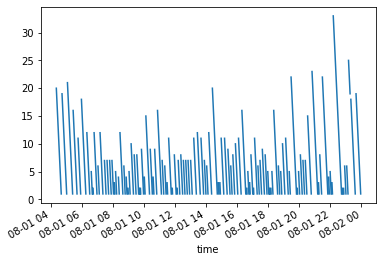

In [20]:
pd.read_hdf('../data/raw/status/status_northbound_n_new/201808/20180801.h5', key='min_until_train')['R16N'].plot()

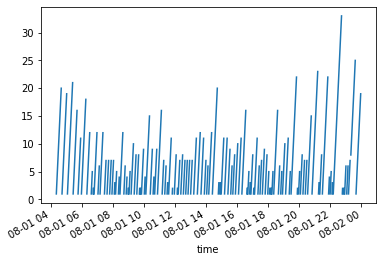

In [21]:
pd.read_hdf('../data/raw/status/status_northbound_n_new/201808/20180801.h5', key='min_since_train')['R16N'].plot()